## Робота №3. Вплив розміру наночастинки на теплові властивості матеріалу

## Мета роботи
Визначення температури плавлення і теплових властивостей наночастинок різного розміру
методом молекулярної динаміки.

## Об'єкт дослідження
Зразки чистих металів нанометрових розмірів.

## Програма проведення експерименту

Створити циліндричний кристал з $r=5$ елементарних комірок і довжиною 7 елементарних
комірок вздовж напрямку $\left<100\right>$ з вільними граничними умовами. Матеріал: _Au_. Підвищувати температуру через кожні 200 кроків на $10 \dots 50~K$ з $\approx0.4$ до $\approx1.8~T_{пл}$. Використовуємо наступний код для `xmd`.

In [2]:
%%writefile lab3.xm
read ../pot/Au_xmd.eam
# 'Melting point': '1337.33 K'
FILL BOUNDARY CYLINDER $1 $2 $3 $4 $5 1 0 0
fill particle 4 # FCC
1     0.0        0.0        0.0
1     0.5        0.0        0.5
1     0.5        0.5        0.0
1     0.0        0.5        0.5

fill align 10 10 10
fill cell
1 0 0
0 1 0
0 0 1
fill go

box 40 40 40

# Set initial temp variable
calc TEMP=535

# Set adiabatic simulation at starting temperature of 535K
dtime 9e-15
clamp off

scale A0
select all
mass MASS

itemp TEMP

cmd 200

eunit eV
ESAVE 100 lab3_$6.energy

# Do 100 separate runs of 100 steps each
repeat 200
    itemp TEMP
    cmd 100
    WRITE PDB +lab3_$6.pdb
    WRITE FILE +lab3_$6.temperature TEMP
    calc TEMP=TEMP+10
end

Overwriting lab3.xm


In [3]:
for i, r in enumerate([2.6, 5.2, 10]): # r
    %echo off
    !del /f lab3_{i}.temperature
    !del /f lab3_{i}.pdb
    !xmd lab3.xm {r} 7 20 20 20 {i} > lab3_{i}.log # r l Xc Yc Zc experiment_number

Знаходимо температуру плавлення за втратою дальнього порядку. Спершу визначаємо номер фрейму, на якому вже втрачається дальній порядок.

In [1]:
frames = [35, 58, 70]
print(f'Номери фреймів: {frames}')

Номери фреймів: [35, 58, 70]


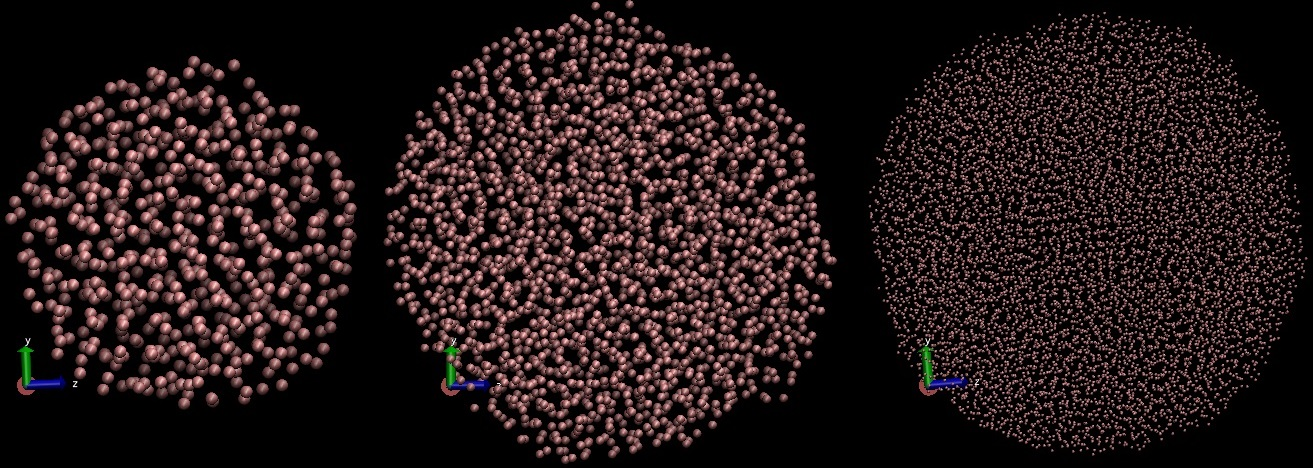

In [10]:
from IPython.display import Image
Image(filename='lab3.jpg')

Знаходимо значення температур, які відповідають знімкам.

In [2]:
import pandas as pd

def read_data(name_temp, name_energy):
    data_frame = pd.read_csv(name_energy, delimiter=' ', skipinitialspace=True,
                                     names=['step', 'Etot', 'Epot', 'E_k'], index_col=False)
    data_frame['temp'] = pd.read_csv(name_temp, delimiter=' ', skipinitialspace=True, names=['str', 'temp']).temp
    return data_frame

data = list()
for i in range(3):
    data.append(read_data(f'lab3_{i}.temperature', f'lab3_{i}.energy'))
    data[i].index += 1

melting_temps = list()
for i, frame in enumerate(frames):
    melting_temps.append(data[i].iloc[frame]['temp'])

dfsummary = pd.DataFrame({'r':[2.6, 5.2, 10], 'T_melting':melting_temps})
dfsummary

,T_melting,r
0,894.330,2.6
1,1121.067,5.2
2,1204.194,10.0


З файлів `*.energy`, в якому по колонках записані `Nstep; E_total; E_pot=U; E_kin~T; (еВ, ерг або Дж)`, використовуємо значення потенціальної енергії, що визначається положенням
атомів, а температуру з файлів `*.temperature` ($K$). Будуємо графіки $U=f(T)$:

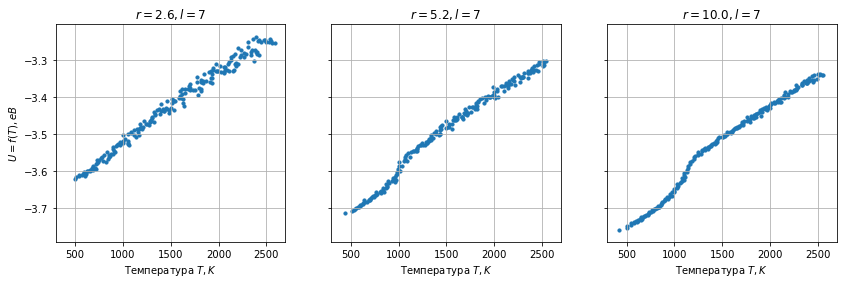

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['axes.grid'] = True

f1, ax1 = plt.subplots(1, 3, sharey=True, sharex=True, figsize=(14,4))

for n, dat in enumerate(data):
    ax1[n].scatter(dat.temp, dat.Epot, s=10)
    ax1[n].set_xlabel('Температура $T, K$')
    ax1[n].set_title(f'$r={dfsummary.r[n]}, l=7$')
    
ax1[0].set_ylabel(r'$U=f(T), еВ$')

Знаходимо температуру плавлення за перегином при апроксимації прямими (зміна теплоємності), за
ростом $U$ при постійній $T$ та за допомогою візуального контролю структури в VMD
по зникненню далекого порядку.

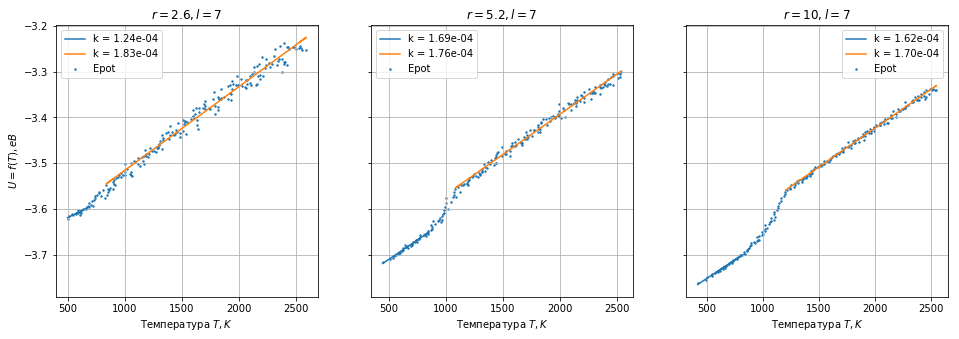

In [4]:
import numpy as np

# plotting
f2, ax2 = plt.subplots(1, 3, sharey=True, figsize=(16,5))

it = iter([0, 1, 2])
r = iter([2.6, 5.2, 10])
gap = iter([20, 25, 40])

C_before = list()
C_after = list()
E_melting = list()
T_melt_start =list()

for frame, sample in zip(frames, data):
    b, _, a = pd.np.split(sample, [frame-next(gap), frame], axis=0)
    line_b = np.poly1d(pd.np.polyfit(b.temp, b.Epot, 1))
    line_a = np.poly1d(pd.np.polyfit(a.temp, a.Epot, 1))
    
    n = next(it)
    
    C_before.append(line_b.c[0])
    C_after.append(line_a.c[0])
    
    E_melting.append(a.Epot.iloc[0]-b.Epot.iloc[-1])
    T_melt_start.append(b.temp.iloc[-1])
    
    ax2[n].scatter(sample.temp, sample.Epot, s=2)
    
    ax2[n].plot(b.temp, line_b(b.temp), label=f'k = {line_b.c[0]:.2e}')
    ax2[n].plot(a.temp, line_a(a.temp), label=f'k = {line_a.c[0]:.2e}')
    
    ax2[n].legend()
    
    ax2[n].set_xlabel('Температура $T, K$')
    ax2[n].set_title(f'$r={next(r)}, l=7$')

    ax2[0].set_ylabel(r'$U=f(T), еВ$')
    
dfsummary['E_melting'] = E_melting

dfsummary['T_melt_start'] = T_melt_start

In [5]:
dfsummary['C_before'] = np.array(C_before) * 1.6e-19 * 6.02e23
dfsummary['C_after'] = np.array(C_after) * 1.6e-19 * 6.02e23

dfsummary['T_mean'] = (dfsummary.T_melting + dfsummary.T_melt_start) / 2
dfsummary['FusionEnthalpy'] = (dfsummary.E_melting) / (dfsummary.T_mean) * 1.6e-19 * 6.02e23
dfsummary

,T_melting,r,E_melting,T_melt_start,C_before,C_after,T_mean,FusionEnthalpy
0,894.330,2.6,0.040880,665.6345,11.941327,17.606487,779.98225,5.048271
1,1121.067,5.2,0.087804,840.7895,16.248205,16.941370,980.92825,8.621712
2,1204.194,10.0,0.136341,816.6280,15.618614,16.359539,1010.41100,12.997053


Enthalpy of Fusion - 12.7 kJ/mol

Isobaric Molar Heat Capacity 25.418 J/(mol K) (298.15 K, 1 bar)

In [98]:
from scipy.optimize import fmin

In [105]:
x_new = np.linspace(2.6, 10, 100)
x = dfsummary.r
y = dfsummary.T_melting

def cost(c, X=x, y=y):
    return np.sum((y-(c[0]+c[1]*np.log(X)))**2)

coeff = fmin(cost, [1, 1])
coeff[0]

Optimization terminated successfully.
         Current function value: 3018.142492
         Iterations: 99
         Function evaluations: 191


695.38196804162408

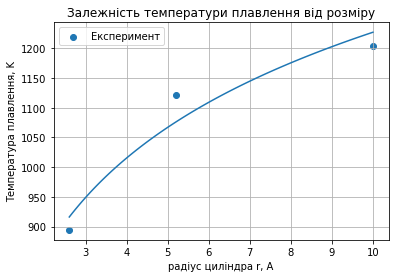

In [106]:
plt.scatter(x, y, label='Експеримент')
plt.plot(x_new, coeff[0]+coeff[1] * np.log(x_new))

plt.title('Залежність температури плавлення від розміру')
plt.xlabel('радіус циліндра r, A')
plt.ylabel('Температура плавлення, K')
plt.legend()

In [96]:
coeff.x

array([ 1071.56154767])